In [1]:
import numpy as np 
import emcee
import matplotlib.pyplot as pl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal
import time 
import corner
import h5py
#import ipdb
from scipy import integrate 

# Basic definitions

In [2]:
# magnitude of speed of light
cmag = 149896229 / 500

In [3]:
# Redshifts for the bins that we chose when we did the eigevector analysis with Fisher.
zzmin = 0.03
zzmax = 1.7
zbins = zzmin + np.linspace(zzmin, zzmax, 500)


- Import the eigenfunctions from the mathematica output file.

In [4]:
# ## Add code here to read of the e_i eigenvectors
# eigenvectors = [[0] * 850 for _ in range(500)]
# eigenvectors = np.array(eigenvectors)

eigenvectors = np.loadtxt("/gpfs/home/argiannakopo/cosmo_temp/eigenvectorsFisherTot.dat")
eigenvectors.shape

(500, 500)

In [5]:
## Define DE equation of state as a sum over the eigenvectors times some coefficient alpha

# This function returns an array [1, number of z bins] which corresponds DE EoS for each redshift in each bin.
def w(alphas,eigenvectors):
    
    weighted_eigenvectors = alphas[:,np.newaxis] * eigenvectors

    summed_vector = -1 + np.sum(weighted_eigenvectors, axis=0)

    return -1 + summed_vector
    
    

In [6]:
# # Test variables used to make sure things work. They have no meaning.
# testbins = np.linspace(0.01,1,5)
# testalp = np.linspace(0.01, 0.1, 5)
# testvecs = np.array([[1] * 5 for _ in range(5)])
# testsigma2 = np.linspace(0.1,0.2,5)

In [7]:
def omegade(zbins, alphas, eigenvectors):

    base = (1 + zbins)
    power = 3 * ( 1 + w(alphas,eigenvectors))

    return base ** power
    

In [8]:
# ## Different definition to avoid overflow errors
# def omegade(zbins, alphas, eigenvectors):
#     base = (1 + zbins)
#     power = 3 * (1 + w(alphas, eigenvectors))
    
#     # Calculate the exponent using logarithm to avoid overflow
#     log_result = np.log(base) * power

#     # Take the exponent of the result to get the final value
#     return np.exp(log_result)

- The way I defined things, I have an issue with luminosity distance $d_L$ since my bins from summing the eigenvectors go from $z_{min}$ to $z_{max}$ with $z_{min} \neq 0$. However, in the definition of the luminosity distance I have an integral from 0 to z. To deal with this part of $z < z_{min}$, I will evaluate a constant factor with $w_{DE} = w_{fid} = -1$ and add this to each element of the array within the zbins that I care about.


In [9]:
## I need to figure out how to define angular distance 

def hubble(zbins, alphas, eigenvectors, H0, Om, Ok ):

    x = 1 - Om - Ok 
    
    if x < 0:
        print("Error: Bad Input, Om, Ok")
    else:
        return np.array( H0 * np.sqrt( Om * ( 1 + zbins) ** 3 + x * omegade(zbins, alphas, eigenvectors) + Ok * (1 + zbins)**2) )



In [10]:
## Define the comoving distance. 
## Since the zbins start at zmin, I will break the integral in two pieces: [0,zmin) and [zmin,z]

## This function return a numpy array that gives the comoving distance at each redshift bin. 
def comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok):
    x = 1 - Om - Ok
    if x < 0:
        return print('Comoving dist: Bad Input, Om, Ok')
    else:
        # Bin the [0, zmin] interval and do the integration
        x1, x2 = 0, zbins[0]
        Nx = 5 + 5 * int(abs(x2 - x1) * 100)
        dx = (x2 - x1) / Nx
        dz = zbins[1] - zbins[0]
        less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (H0 * np.sqrt(Om * (1 + x1 + dx * i)**3 + x * (1+ x1 + dx * i) + Ok * (1 + x1 + dx * i)**2)))(i) for i in range(0, Nx))
        less_zmin =  np.sum(less_zmin_arr)
        
        return cmag * less_zmin +  cmag * np.cumsum( dz / hubble(zbins, alphas, eigenvectors, H0, Om, Ok))
    
    

In [11]:
## Returns an array of luminosity distances at each redshift z 
def lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok):
    z_shifted = 1 + zbins

    return z_shifted * comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok)
    

In [12]:
# ## Testing
# lum_distance(testbins, testalp, testvecs, 73, 0.24, 0.0)

In [13]:
# Define the logarithm of dL
# Returns the logarithm of the array of luminosity distance for each redshift bin
def log_h0dl(zbins, alphas, eigenvectors, H0, Om, Ok):
    return np.log10( (H0 / cmag) * lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok))
    



In [14]:
# ## Testing
# start_time = time.time()
# x = log_h0dl(testbins, testalp, testvecs, 74, 0.24, 0.0)
# end_time = time.time()
# print("time it took:", end_time - start_time)
# x


# SN $\sigma^2$ definition

In [15]:
NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0]
zSN = [0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.75]
SNpoints = list(zip(zSN, NSN))


In [16]:
# Create an interpolation function for the number of SN 

fNSN = interp1d(zSN, NSN, kind='linear', fill_value='extrapolate')


# # Generate new z values for interpolation
# z_values_interpolated = np.linspace(min(zSN), max(zSN), 1000)

# # Interpolate NSN values for the new z values
# NSN_interpolated = fNSN(z_values_interpolated)


In [17]:
zBinsFisher = np.linspace(0.0334, 1.7, 500)

# This function returns the sigma^2 error defined in equation (A2)

def Sigma2SNFisher(i, Nz):        
    zzmin = 0.0334
    zzmax = 1.7
    zBinsFisher = np.linspace(zzmin, zzmax, Nz + 1)

    if i > len(zBinsFisher):
        raise ValueError("Index 'i' is out of range.")

    dz1 = 0.1
    dz2 = 0.07
    tmp = zBinsFisher[1] - zBinsFisher[0]

    z_i = zBinsFisher[i]  

    if z_i < 0.1:
        return dz2 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)
    else:
        return dz1 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)

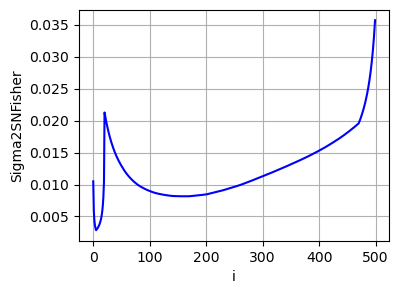

In [18]:
# Test plot to make sure everything works so far

i_values = range(0, len(zBinsFisher))

# Compute Sigma2SNFisher for each i value (each redshift bin of interest)
sigma2_values = [Sigma2SNFisher(i,500) for i in i_values]
sigma2_values = np.array(sigma2_values)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(i_values, sigma2_values, linestyle='-', color='b')
plt.xlabel('i')
plt.ylabel('Sigma2SNFisher')
plt.grid(True)
plt.show()

# SN $\chi^2$ definition

In [19]:
#############################################
### NOT SURE THIS IS NEEDED -- CHECK IT ####
###########################################

# # Interpolate the expressions of the eigenfunctions for the z range that I care about [0.03,1.7]
# eigenvec_interp = [[0] * len(eigenvectors[0]) for _ in range(len(eigenvectors))]

# for i in range(len(eigenvectors)):
#     interp_fun = interp1d(zbins, eigenvectors[i], kind='linear')
#     eigenvec_interp[i] = interp_fun(zBinsFisher)

# eigenvec_interp = np.array(eigenvec_interp)
# eigenvec_interp.shape

Now I have a table 500x500 that only includes the eigenvectors in the redshift range that I am interested in. For the rest I need to use zBinsFisher instead of zbins.

In [20]:
# This function takes as input the zbins, amplitudes alpha, eigenvectors,  error values and cosmo parameters
# and returns the chi^2 based on SN (equation A6 from ref)

def chi_squared_sn(alphas, Om, Omh2, Ok, zBinsFisher, eigenvectors, sigma2_values):
    
    H0 = np.sqrt(Omh2/Om) * 100
    # Difference between MCMC model and fiducial model
    alphas_fid = np.array([0] * len(eigenvectors))
    diff = log_h0dl(zBinsFisher, alphas, eigenvectors, H0, Om, Ok) - log_h0dl(zBinsFisher, alphas_fid, eigenvectors, 73, 0.24, 0.0)

    return 5 * np.sum( diff**2 / sigma2_values) - 25 * np.sum(diff / sigma2_values) / np.sum(1 / sigma2_values)  
    


In [21]:
# ## Testing
# chi_squared_sn(testbins, testalp, testvecs, testsigma2, 73, 0.24, 0.0 )

# Definition of CMB part including radiation

In [22]:
# Define some basic parameters following the PCA construnction

NNU = 3.04
TCMB = 2.725
OGhh = 4.4856e-7 * TCMB ** 4
ONhh = 1.0187e-7 * NNU * TCMB ** 4
ORhh = ONhh + OGhh
zrec = 1090

In [23]:
# covariance matrix
CMBCov = np.array([[0.0018**2, -(0.0014)**2],[-(0.0014)**2, 0.0011**2]])
invCMBCov = np.linalg.inv(CMBCov)

- In this case again I need to be careful how I define the distances because I care about $z_{rec}=1090$.

In [24]:
## I need to figure out how to define angular distance 

def hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):

    h2 = Omh2 / Om
    x = h2 - Omh2 - Ok * h2 - ORhh

    if x < 0:
        print("Error: Bad Input, x")
    else:
        return np.array( 100 * np.sqrt( Omh2 * ( 1 + zbins) ** 3 + x * omegade(zbins, alphas, eigenvectors) + Ok * h2 * (1 + zbins)**3 + ORhh * (1+zbins)**4 ) )



In [25]:
# ## Testing
# hubble_rad(testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0.0, ORhh)

- I need to redefine the comoving distance using the new Hubble function

In [26]:

# ## This function return the comoving distance to redshift z. 
# ## Here I want to extend to redshifts that are zmax of the zbins. 

# def comov_dist_rad(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    
#     h2 = Omh2 / Om
#     x = h2 - Omh2 - Ok * h2 - ORhh
    
#     if x < 0:
#         return print('Comoving dist rad: Bad Input, Om, Ok')
#     else:
#         if z < zbins[0]:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, z
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)
            
#             return cmag * less_zmin 
            
#         if z <= zbins[-1] and z >= zbins[0]:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, zbins[0]
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             dz = zbins[1] - zbins[0]
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)
#             # Use boolean mask to only sum up to z and not the rest of the bins. 
#             z_mask = zbins <= z 
            
#             # Discard the z bins that exceed z
#             zbins = zbins[z_mask]
            
#             # Discard the eigenvector bins that exceed z.
#             eigenvectors = eigenvectors[:,:len(zbins)]
            
#             return cmag * less_zmin +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh))
    
            
#         else:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, zbins[0]
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             dz = zbins[1] - zbins[0]
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx *i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)

#             x3, x4 = zbins[-1], z
#             Nx2 = 5 + 5 * int(abs(x4 - x3) * 100)
#             dx2 =(x4 - x3 ) / Nx2
#             larger_zmax_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx2 / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx2))
#             larger_zmax = np.sum(larger_zmax_arr)
            
#             return cmag * less_zmin +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)) + cmag * larger_zmax
            
        

In [27]:
# ## Test
# start_time = time.time()
# x = comov_dist_rad(0.5, testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0, ORhh)
# end_time = time.time()
# print("comp time:", end_time - start_time)
# x


- Faster version to compute comoving distance taking into account radiation. 

In [28]:
## This function return the comoving distance to redshift z. 
## I will try different integration methods to speed things up 

#################################################################
##### Comoving distance using the scipy integrate function #####
###############################################################

def comov_dist_rad_fast(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    
    h2 = Omh2 / Om
    x = h2 - Omh2 - Ok * h2 - ORhh
    dz = zbins[1] - zbins[0]
    
    if x < 0:
        return print('Comoving dist rad fast: Bad Input, Om, Ok', Om, Ok)
    else:
        def f(x1,x, Ok, h2, ORhh):
            return 1 / (100 * np.sqrt(Omh2 * (1 + x1)**3 + x * (1+ x1) + Ok * h2 * (1 + x1 )**3 + ORhh * (1+ x1 ) ** 4))
    
        if z < zbins[0]:
            return cmag * integrate.quad(f,0, z, args=(x, Ok, h2, ORhh))[0]
                
        if z <= zbins[-1] and z >= zbins[0]:
            z_less = integrate.quad(f,0,zbins[0], args=(x, Ok, h2, ORhh))
            # Use boolean mask to only sum up to z and not the rest of the bins. 
            z_mask = zbins <= z 
            
            # Discard the z bins that exceed z
            zbins = zbins[z_mask]
            
            # Discard the eigenvector bins that exceed z.
            eigenvectors = eigenvectors[:,:len(zbins)]
            
            return cmag * z_less[0] +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh))
        if z > zbins[-1]:
            z_less = integrate.quad(f,0,zbins[0],args=(x, Ok, h2, ORhh))
            z_more = integrate.quad(f, zbins[-1], z, args=(x, Ok, h2, ORhh))
            
            return cmag * z_less[0] +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)) + cmag * z_more[0]
            
        

In [29]:
# ## Testing
# start_time = time.time()
# x = comov_dist_rad_fast(0.5, testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

- The $D_a$ function below works correctly only for redshift values z that are larger than the range covered by the SN measurements i.e. larger than $z_{max}$ in $z_{bins}$. However, since I only care about the $z_{rec}$ distance, this is not a problem.

In [30]:
## This function returns the angular distance for redshift z. 
## NOTE: This works for z > zbins interval, but since I am interested in zrec that is okay.
def angular_dist(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):

    h2 = Omh2 / Om
    comov_dist = comov_dist_rad_fast(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)
    
    if Ok > 0 :
        return  cmag / ((1 + z ) * 100 * h2 * np.sqrt(np.abs(Ok))) * np.sinh( (1/cmag) * np.sqrt(Ok) * 100 * h2 * comov_dist )   
    
    elif Ok < 0 :
        return cmag / ((1 + z ) * 100 * h2 * np.sqrt(np.abs(Ok))) * np.sin((1/cmag) * np.sqrt(-Ok) * 100 * h2 * comov_dist )
        
    elif Ok == 0:
        return comov_dist / ( 1 + z)
        

In [31]:
# ## Testing
# start_time = time.time()
# x = angular_dist(1090, testbins, testalp, testvecs, 0.24 * 0.73 **2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

In [32]:
def ln_angular_dist(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    return np.log( angular_dist(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh) )

In [33]:
# ## Testing
# start_time = time.time()
# x = ln_angular_dist(1090, testbins, testalp, testvecs, 0.24 * 0.73 **2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

# CMB $\chi^2$ definition

In [34]:
## Fiducial model angluar distance to z_rec
alphas_fid = np.array([0] * len(eigenvectors))
lnd_angular_rec_fid = ln_angular_dist(zrec, zbins, alphas_fid, eigenvectors, 0.24 * 0.73**2, 0.24, 0.0, ORhh)

In [35]:
# CMB contribution to χ^2

def chi_squared_cmb(alphas, eigenvectors, invCMBCov, lnd_ang_rec_fid, Omh2, Om, Ok, ORhh):
    zrec = 1090
    Omh2_fid = 0.24 * 0.73 ** 2
    diff1 = ln_angular_dist(zrec, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh) - lnd_ang_rec_fid 
    diff2 = Omh2 - Omh2_fid
    

    vec = np.array([diff1, diff2])
    return np.matmul( np.matmul(vec,invCMBCov), vec)   


# Priors

- Refer to equation (A8) from Mortonson et al 0810.1744

In [36]:
# Angular distance to z=0.35 in the fiducial model
ln_angular_0p35_fid = ln_angular_dist(0.35, zbins, alphas_fid, eigenvectors, 0.24 * 0.73 ** 2, 0.24, 0.0, ORhh)


For the theory prior below, I can rewrite equation (A10) as:

$ \alpha_i^{\pm} = \frac{1}{2N_{z,PC}} \left[ \left( w_{min} + w_{max} - 2 w_{fid} \right) \sum_{j=1}^{N_{z,PC}} e_i (z_j) \pm \left( w_{max} - w_{min} \right) \sum_{j=1}^{N_{z,PC}} \lvert e_i (z_j) \rvert \right]$.

Taking advangate of that, I first calculate the two sums, then weigh the arrays appropriately and sum/take the difference.

In [37]:
# h prior 

def chi_squared_prior(Nz, eigenvectors, eigenvectorsNc, alphas, zbins, Omh2, Om, Ok, ORhh, ln_angular_0p35_fid):

    # Amplitudes prior 
    # Theoretical limits on DE
    wfid = -1
    # Quintessense 
    wmin, wmax = -1, 1
    # Smooth DE
    # wmin, wmax = -5, 3

    weight1 = wmin + wmax - 2 * wfid
    weight2 = wmax - wmin 

    # First I need to calculate each of the two relevant sums in the eq (A10)
    first_sum = np.sum(eigenvectors, axis=1)
    second_sum = np.sum(np.abs(eigenvectors), axis=1)
    
    # alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
    alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
    alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

    # Top hat prior on the amplitudes.
    # Here I have assumed that I am only intrested in the first 15 alphas i.e. I only want to keep the first 15 eigenfunctions. 
    # ## NOTE: Be very careful with the definition of the if not statement! 
    # if  not (np.all(alphas < alpha_max[:2]) and not np.all(alphas > alpha_min[:2])):
    #     return - np.inf
    if np.any(alphas < alpha_min[:2]) or np.any(alphas > alpha_max[:2]):
        return -np.inf
    
    # h prior
    sigma_h = 0.08
    h_prior = -0.5 * ( np.sqrt(Omh2 / Om) - 0.73) ** 2 / sigma_h ** 2
    
    # BAO prior
    sigma_bao = 0.037
    bao_prior = -0.5 * ( ln_angular_dist(0.35, zbins, alphas, eigenvectorsNc, Omh2, Om, Ok, ORhh) - ln_angular_0p35_fid ) ** 2 / sigma_bao ** 2
    
    # WMAP prior on DE
    sigma_de = 0.025
    de_prior = - 0.5 * ( (1 - Om - Ok) - (1 - 0.24)) ** 2 / sigma_de ** 2
    
    # out = h_prior + bao_prior + de_prior
    # if (out < 0  and out > -0.05) or out > 10**5:
    #     print(h_prior, bao_prior, de_prior)
    
    return h_prior + bao_prior + de_prior   
    

# Function to Sample 

- In order to calculate the $\chi^2$ for SN I interpolate the eigenfunctions based on the finer z binning (N=850) and then I truncate it between the redshift values that I am interested in i.e. $z \in [0.03,1.7]$. On the other hand, when I calculate the $\chi^2$ for CMB I use all the available bins (no interpolation) plus the extra parts for $z < z_{bin}^{min}$ and $ z > z_{bin}^{max}$, since I am interested in the specific distance from recombination i.e. $z_{rec} \simeq 1090$. Based on this, I think I can sum the two $\chi^2$ and be correct.

- The parameters that are relevant and will sample from are (eq4 in ref): $\theta_{base} = \{ \alpha_1, ..., \alpha_{N_c}, \Omega_m, \Omega_m h^2 \}$ with $N_c =15$.

In [38]:
# In this function I need to define all the parameters I dont want to sample and leave inside "theta" the parameters I want to sample with my MCMC

def lnprob(theta, Ok, zBinsFisher, eigenvectors, eigenvectorsNc, sigma_values, invCMBCov, lnd_ang_rec_fid,  ln_angular_0p35_fid, Nz):
    alphaNc = theta[:2]  # Take first 15 variables in theta as alphaNc
    Om, Omh2 = theta[2], theta[3]  # Remaining parameters
    NNU = 3.04
    TCMB = 2.725
    OGhh = 4.4856e-7 * TCMB ** 4
    ONhh = 1.0187e-7 * NNU * TCMB ** 4
    ORhh = ONhh + OGhh
    
    if Om < 0 or Om > 0.4 or Omh2 < (ORhh * Om) / (1 - Om) :
        return -np.inf
    
    H0 = np.sqrt( Omh2 / Om )
    
    return - 0.5 * ( chi_squared_sn(alphaNc, Om, Omh2, Ok, zBinsFisher, eigenvectorsNc, sigma2_values) +  
                    chi_squared_cmb(alphaNc, eigenvectorsNc, invCMBCov, lnd_ang_rec_fid, Omh2, Om, Ok, ORhh)) + chi_squared_prior(Nz, eigenvectors, eigenvectorsNc,  alphaNc, zBinsFisher, Omh2, Om, Ok, ORhh, ln_angular_0p35_fid) 


# MCMC set up 

In [39]:
# nwalkers = 64
# ndim = 17
# # fiducial model = [{amp}, Om, Omh2]
# amps_fid = np.array([0]*15)
# fiducial = np.concatenate([amps_fid, [0.24, 0.24*0.73**2]])
# p0 = [fiducial + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]
# #p0 = [fiducial + np.concatenate((1e-1 * np.random.randn(2), 1e-3 * np.random.randn(2))) for i in range(nwalkers)]

In [40]:
# nwalkers = 15
# ndim = 4
# # fiducial model = [{amp}, Om, Omh2]
# amps_fid = np.array([0]*2)
# fiducial = np.concatenate([amps_fid, [0.24, 0.24*0.73**2]])

# # Generate the initial guesses in a ball around the fiducial model
# # Add noise using random numbers from  0.1 * (-1,1)

# p0 = [fiducial + 0.1 * (2 * np.random.rand(ndim) - 1) for i in range(nwalkers)]

# #p0 = [fiducial + np.concatenate((1e-1 * np.random.randn(2), 1e-3 * np.random.randn(2))) for i in range(nwalkers)]



In [41]:
## Make sure that the initial positions p0 are generated inside the allowed area for the parameters
nwalkers = 15
ndim = 4
# fiducial model = [{amp}, Om, Omh2]
amps_fid = np.array([0]*2)
fiducial = np.concatenate([amps_fid, [0.24, 0.24*0.73**2]])

# Define the min and max allowed values for each parameter
# Theoretical limits on DE
wfid = -1
# Quintessense 
wmin, wmax = -1, 1
# Smooth DE
# wmin, wmax = -5, 3
Nz = 500
weight1 = wmin + wmax - 2 * wfid
weight2 = wmax - wmin 

# First I need to calculate each of the two relevant sums in the eq (A10)
first_sum = np.sum(eigenvectors, axis=1)
second_sum = np.sum(np.abs(eigenvectors), axis=1)

# alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

# Generate the initial guesses in a ball around the fiducial model
# Add noise using random numbers from  0.1 * (-1,1)
p0 = [ fiducial + np.concatenate(((alpha_min[:2] * 1e-2 * np.abs(2*np.random.rand(2) - 1)), 0.1*(2*np.random.rand(2) - 1))) for i in range(nwalkers)]


- Set up the backend so that I can save the chains
- Don't forget to clear the file in case it already exists

In [42]:
filename = "/gpfs/scratch/argiannakopo/2troubleshooting_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


In [43]:
## I will only use the 15 first eigenvectors

eigenvectors15 = eigenvectors[:2, ::]

In [44]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[0.0, zBinsFisher, eigenvectors, eigenvectors15, sigma2_values, 
                                                              invCMBCov, lnd_angular_rec_fid , ln_angular_0p35_fid, 500], backend=backend)


In [45]:
max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    # If the chain is longer than 100 times the estimated autocorrelation time and 
    # if this estimate changed by less than 1%, we’ll consider things converged.
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

You must install the tqdm library to use progress indicators with emcee


emcee: Exception while calling your likelihood function:
  params: [-0.00028502 -0.00037681  0.13774376  0.23552338]
  args: [0.0, array([0.0334    , 0.03673988, 0.04007976, 0.04341964, 0.04675952,
       0.0500994 , 0.05343928, 0.05677916, 0.06011904, 0.06345892,
       0.0667988 , 0.07013868, 0.07347856, 0.07681844, 0.08015832,
       0.0834982 , 0.08683808, 0.09017796, 0.09351784, 0.09685772,
       0.1001976 , 0.10353747, 0.10687735, 0.11021723, 0.11355711,
       0.11689699, 0.12023687, 0.12357675, 0.12691663, 0.13025651,
       0.13359639, 0.13693627, 0.14027615, 0.14361603, 0.14695591,
       0.15029579, 0.15363567, 0.15697555, 0.16031543, 0.16365531,
       0.16699519, 0.17033507, 0.17367495, 0.17701483, 0.18035471,
       0.18369459, 0.18703447, 0.19037435, 0.19371423, 0.19705411,
       0.20039399, 0.20373387, 0.20707375, 0.21041363, 0.21375351,
       0.21709339, 0.22043327, 0.22377315, 0.22711303, 0.23045291,
       0.23379279, 0.23713267, 0.24047255, 0.24381242, 0.2471523 

Traceback (most recent call last):
  File "/gpfs/home/argiannakopo/.conda/envs/Jupyter/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_14616/2295867502.py", line 17, in lnprob
    return - 0.5 * ( chi_squared_sn(alphaNc, Om, Omh2, Ok, zBinsFisher, eigenvectorsNc, sigma2_values) +
  File "/tmp/ipykernel_14616/2414217888.py", line 9, in chi_squared_sn
    diff = log_h0dl(zBinsFisher, alphas, eigenvectors, H0, Om, Ok) - log_h0dl(zBinsFisher, alphas_fid, eigenvectors, 73, 0.24, 0.0)
  File "/tmp/ipykernel_14616/779949343.py", line 4, in log_h0dl
    return np.log10( (H0 / cmag) * lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok))
  File "/tmp/ipykernel_14616/902011395.py", line 5, in lum_distance
    return z_shifted * comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok)
  File "/tmp/ipykernel_14616/1947627492.py", line 15, in comov_dist
    less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i:

KeyboardInterrupt: 

# Read from file MCMC chain 

In [ ]:
# Read the sampler results from the save file

filename = "/gpfs/scratch/argiannakopo/2troubleshooting_MCMC.h5"
reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
#log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
#log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
#print("flat log prob shape: {0}".format(log_prob_samples.shape))
#print("flat log prior shape: {0}".format(log_prior_samples.shape))

In [5]:
print(tau)

NameError: name 'tau' is not defined

In [6]:
reader.get_chain().shape

(4279, 15, 4)

In [7]:
import corner

tau = reader.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
samples = reader.get_chain(flat=True)
log_prob_samples = reader.get_log_prob(flat=True)
log_prior_samples = reader.get_blobs(flat=True)

# print("burn-in: {0}".format(burnin))
# print("thin: {0}".format(thin))
# print("flat chain shape: {0}".format(samples.shape))
# #print("flat log prob shape: {0}".format(log_prob_samples.shape))
# #print("flat log prior shape: {0}".format(log_prior_samples.shape))

# # all_samples = np.concatenate(
# #     (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
# )

labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
#labels += ["log prob", "log prior"]

corner.corner(samples, labels=labels);

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 86;
tau: [91.38935144 86.99979428 79.34039252 29.17014719]

In [8]:
import corner

# Get the samples for the first 3 parameters
first_three_params_samples = samples[:, 14:17]

# Define labels for the first 3 parameters
labels = list(map(r"$\theta_{{{0}}}$".format, range(14, 17)))

# Plot the corner plot
corner.corner(first_three_params_samples, labels=labels);


NameError: name 'samples' is not defined